In [2]:
from itertools import product
import random
from sklearn.feature_selection import mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cmim import fast_cmim, CMIM_INFO

In [3]:
DF = None
DF_ARGS = {}

def standardize_df(df):
    # Standardize data
    df_std = (df - df.mean()) / df.std()
    return df_std

def read_dataframe(path = "Acoustic-Features.csv", map_ = {"relax":0, "happy":1, "sad":2, "angry":3}, shuffle = True, standardize = False):
    """ Read the dataframe and return it.
    """
    global DF, DF_ARGS
    if (DF is not None) and DF_ARGS["path"] == path and DF_ARGS["map_"] == map_ and DF_ARGS["shuffle"] == shuffle and DF_ARGS["standardize"] == standardize:
        # Check if df is mapped
        if DF["Class"].dtype == "object":
            DF["Class"] = DF["Class"].map(map_)
        return DF
    df = pd.read_csv(path)
    DF = df.copy()
    DF_ARGS = {"path":path, "map_":map_, "shuffle":shuffle, "standardize":standardize}
    if map_:
        df["Class"] = df["Class"].map(map_)
    if shuffle:
        # set seed for reproducibility
        np.random.seed(42)
        df = df.sample(frac=1,random_state=43).reset_index(drop=True)
    if standardize:
        df = standardize_df(df)
    return df

In [4]:
def split_data(df, test_size=0.25, label="Class"):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    train_y = train_df.pop(label)
    test_y = test_df.pop(label)
    train_X = train_df
    test_X = test_df
    return train_X, train_y, test_X, test_y

def test_model(model, test_X, test_y):
    """ Returns accuracy, recall, precision, f1 score of a model.
    """
    assert hasattr(model, "predict"), "Model must have a predict method"
    pred = model.predict(test_X)
    acc = accuracy_score(test_y, pred)
    recall = recall_score(test_y, pred, average="macro")
    precision = precision_score(test_y, pred, average="macro")
    f1 = f1_score(test_y, pred, average="macro")
    return acc, recall, precision, f1

In [5]:
def print_metrics(acc, recall, precision, f1):
    print("Accuracy: {:.2f}".format(acc))
    print("Recall: {:.2f}".format(recall))
    print("Precision: {:.2f}".format(precision))
    print("F1 score: {:.2f}".format(f1))

PCA_INFO = {}
def pca_dim_reduction(X,y, N=5, **kwargs):
    """ Perform PCA dimensionality reduction.
    If this is called for the first time, it will fit the PCA model and store it in PCA_INFO.
    If this is called for the second time, it will use the PCA model stored in PCA_INFO.
    """
    if PCA_INFO:
        if "standardize" in kwargs and kwargs["standardize"]:
            X_mean = PCA_INFO["X_mean"]
            X_std = PCA_INFO["X_std"]
            X = (X - X_mean) / X_std
        pca = PCA_INFO["pca"]
        X = pca.transform(X)
    else:
        if "standardize" in kwargs and kwargs["standardize"]:
            X_mean = X.mean()
            X_std = X.std()
            PCA_INFO["X_mean"] = X_mean
            PCA_INFO["X_std"] = X_std
            X = (X - X_mean) / X_std
        # Pass kwargs to PCA, excluding standardize
        kwargscopy = kwargs.copy()
        kwargscopy.pop("standardize", None)
        pca = PCA(n_components=N, **kwargscopy)
        X = pca.fit_transform(X)
        PCA_INFO["pca"] = pca
    print("Explained variance ratio: {}".format(pca.explained_variance_ratio_))
    return X,y

In [6]:

SVD_INFO = {}
def svd_dim_reduction(X,y, N=5, **kwargs):
    """ Perform SVD dimensionality reduction.
    If this is called for the first time, it will fit the SVD model and store it in SVD_INFO.
    If this is called for the second time, it will use the SVD model stored in SVD_INFO.
    """
    if SVD_INFO:
        if "standardize" in kwargs and kwargs["standardize"]:
            X_mean = SVD_INFO["X_mean"]
            X_std = SVD_INFO["X_std"]
            X = (X - X_mean) / X_std
        svd = SVD_INFO["svd"]
        X = svd.transform(X)
    else:
        if "standardize" in kwargs and kwargs["standardize"]:
            X_mean = X.mean()
            X_std = X.std()
            SVD_INFO["X_mean"] = X_mean
            SVD_INFO["X_std"] = X_std
            X = (X - X_mean) / X_std
        # Pass kwargs to SVD, excluding standardize
        kwargscopy = kwargs.copy()
        kwargscopy.pop("standardize", None)
        svd = TruncatedSVD(n_components=N, **kwargscopy)
        X = svd.fit_transform(X)
        SVD_INFO["svd"] = svd
    print("Explained variance ratio: {}".format(svd.explained_variance_ratio_))
    return X,y

In [7]:
MIM_INFO = {}
def mut_inf_dim_reduction(X,y, N=5, **kwargs):
    """ Perform mutual information dimensionality reduction.
    If this is called for the first time, it will fit the mutual information model and store it in MUT_INFO.
    If this is called for the second time, it will use the mutual information model stored in MUT_INFO.
    """
    X = X.copy()
    if "standardize" in kwargs and not kwargs["standardize"]:
        Warning("Mutual information dimensionality reduction requires standardization. Setting standardize=True.")
    kwargs.pop("standardize", None)
    # If we are doing inference (test set),
    # use the variables from training set (stored in MUT_INFO)
    if MIM_INFO:
        X_mean = MIM_INFO["X_mean"]
        X_std = MIM_INFO["X_std"]
        X = (X - X_mean) / X_std
        top_feature_indices = MIM_INFO["top_feature_indices"]
    # If not, standardize X and store the variables
    else:
        X_mean = X.mean()
        X_std = X.std()
        MIM_INFO["X_mean"] = X_mean
        MIM_INFO["X_std"] = X_std
        X = (X - X_mean) / X_std
        # Get mutual information of each feature with the label
        mutual_info = mutual_info_classif(X, y, **kwargs)
        top_feature_indices = np.argsort(mutual_info)[::-1][:N]
        MIM_INFO["top_feature_indices"] = top_feature_indices
        print("Selected top features: {}".format(X.columns.values[top_feature_indices]))
    # Select top N features with highest mutual information
    X = X.iloc[:, top_feature_indices]
    return X,y


In [8]:
NOR_INFO = {}
def no_reduction(X,y, N=5, **kwargs):
    """ No dimensionality reduction."""
    X = X.copy()
    # If we are doing inference (test set),
    # use the variables from training set (stored in NOR_INFO)
    if NOR_INFO and "standardize" in kwargs and kwargs["standardize"]:
        X_mean = NOR_INFO["X_mean"]
        X_std = NOR_INFO["X_std"]
        X = (X - X_mean) / X_std
    # If not, standardize X and store the variables
    elif "standardize" in kwargs and kwargs["standardize"]:
        X_mean = X.mean()
        X_std = X.std()
        NOR_INFO["X_mean"] = X_mean
        NOR_INFO["X_std"] = X_std
        X = (X - X_mean) / X_std
    return X,y

In [10]:
DIM_RED_NAMES = (("PCA", pca_dim_reduction),
                 ("SVD", svd_dim_reduction),
                 ("MIM", mut_inf_dim_reduction),
                 ("None", no_reduction),
                 #("CMIM_SKLEARN", cmim_sklearn_dim_reduction),
                 ("CMIM",fast_cmim))
DIM_RED_NAME_TO_INFO = {"PCA":PCA_INFO,
                        "SVD":SVD_INFO,
                        "Mutual Information":MIM_INFO,
                        "None":NOR_INFO,
                        "MIM":MIM_INFO,
                        "CMIM" : CMIM_INFO,
                        #"CMIM_SKLEARN" : CMIM_SKFEATURE_INFO,
                        } # For clearing info


In [11]:
def test_method(dim_red : callable,
                dim_red_kwargs : dict = {},
                knn_kwargs : dict = {},
                rf_kwargs : dict = {},
                N : int = 5,
                plot_confusion_matrix : bool = False,
                ):
    """ Test dimensionality reduction method.
    """
    global DIM_RED_NAMES
    dim_red_name = [name for name, func in DIM_RED_NAMES if func == dim_red]
    if not dim_red_name:
        raise ValueError("dim_red must be one of the following: {}".format(DIM_RED_NAMES))
    dim_red_name = dim_red_name[0]
    print(f"USING {dim_red_name} for dimensionality reduction with args: {dim_red_kwargs}")
    print(f"Reducing to {N} components.")
    print(f"KNN args: {knn_kwargs}")
    print(f"Random Forest args: {rf_kwargs}")
    print()

    # Read data
    df = read_dataframe(standardize=False)
    # Split data
    train_X, train_y, test_X, test_y = split_data(df, test_size=0.25)
    # Apply dimensionality reduction. In the first call, it will fit the model and transform the data.
    # In the second call, it will use the stored parameters (from the first call) to transform the data.
    # This is done to avoid data leakage, and match with a realistic scenario where you might want to run inference on a single example.
    train_X, train_y = dim_red(train_X, train_y, N, **dim_red_kwargs)
    test_X, test_y = dim_red(test_X, test_y, N, **dim_red_kwargs)
    if "standardize" in dim_red_kwargs:
        dim_red_kwargs.pop("standardize")
    print(f"")
    print(f"Selected {train_X.shape[1]} components.")
    DIM_RED_NAME_TO_INFO[dim_red_name].clear()
    # Train classifiers
    knn = KNeighborsClassifier(**knn_kwargs)
    knn.fit(train_X, train_y)
    rf = RandomForestClassifier(random_state=42,**rf_kwargs)
    rf.fit(train_X, train_y)
    # Test classifiers
    knn_metrics = test_model(knn, test_X, test_y)
    rf_metrics = test_model(rf, test_X, test_y)
    # Print metrics
    print("KNN metrics:")
    print_metrics(*knn_metrics)
    print("Random forest metrics:")
    print_metrics(*rf_metrics)
    # Plot
    if plot_confusion_matrix:
        # Plot confusion matrices and show values
        knn_pred = knn.predict(test_X)
        rf_pred = rf.predict(test_X)
        knn_cm = confusion_matrix(test_y, knn_pred)
        rf_cm = confusion_matrix(test_y, rf_pred)
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(knn_cm)
        ax[1].imshow(rf_cm)
        for i in range(2):
            for r in range(4):
                for c in range(4):
                    cm = knn_cm if i == 0 else rf_cm
                    ax[i].text(c, r, cm[r, c], ha="center", va="center", color="w", fontsize=12)
        ax[0].set_title("KNN Confusion Matrix")
        ax[1].set_title("RF Confusion Matrix")
        plt.show()
    MIM_INFO.clear()
    SVD_INFO.clear()
    PCA_INFO.clear()
    NOR_INFO.clear()
    MIM_INFO.clear()
    CMIM_INFO.clear()
    return knn_metrics, rf_metrics

In [12]:
def random_grid_search(param_grid, n_iter):
    keys = param_grid.keys()
    values = param_grid.values()
    all_combinations = list(product(*values))
    for instance in random.sample(all_combinations, n_iter):
        yield dict(zip(keys, instance))

In [13]:

def run_grid_search():
    dim_reds = [fast_cmim, no_reduction, pca_dim_reduction, svd_dim_reduction, mut_inf_dim_reduction]
    # Do grid search for KNN and RF
    knn_kwarg_tests = {"n_neighbors": [1, 4, 8, 16, 32, 64, 128],
                       "weights": ["uniform", "distance"]}
    
    rf_kwarg_tests = {"n_estimators": [20, 50, 100, 200],
                      "max_depth": [None, 1, 2, 3, 6, 10],
                      "min_samples_split": [2, 3, 5, 8],
                      "min_samples_leaf": [1, 2,3, 6],
                      "max_features": ["sqrt", "log2", None],
                      "criterion": ["gini", "entropy"],
    }
    N_vals = [5, 15, 25]
    tests = pd.DataFrame(columns=["dim_red", "N", "standardize", "knn_neighbours", "knn_weights", "rf_estimators", "rf_max_depth", "rf_min_samples_split", "rf_min_samples_leaf", "rf_max_features", "rf_criterion",
                                  "knn_acc", "knn_prec", "knn_rec", "knn_f1", "rf_acc", "rf_prec", "rf_rec", "rf_f1"])
    # Test each dimensionality reduction method
    testn = 0
    obs_best_acc = 0
    for dim_red in dim_reds:
        N_vals_ = N_vals if dim_red != no_reduction else [50]
        for N in N_vals_:
            # Do grid search for KNN and RF
            # Add number of iterations if you want to. Keep knn iters low because there aren't many hyperparameters.
            for knn_kwargs in random_grid_search(knn_kwarg_tests,2):
                for rf_kwargs in random_grid_search(rf_kwarg_tests,2):
                    for standardize in [True, False] if dim_red not in [mut_inf_dim_reduction,fast_cmim] else [True]:
                        testn += 1
                        print(f"TEST {testn}")
                        dim_red_kwargs = {}
                        if dim_red not in [mut_inf_dim_reduction]:
                            dim_red_kwargs = {"standardize": standardize}
                        knn_met, rf_met = test_method(dim_red, dim_red_kwargs=dim_red_kwargs, N=N, knn_kwargs=knn_kwargs, rf_kwargs=rf_kwargs)
                        acc = max(knn_met[0], rf_met[0])
                        if acc > obs_best_acc:
                            obs_best_acc = acc
                            print("NEW BEST ACCURACY: {}".format(acc))
                            print("KNN args: {}".format(knn_kwargs))
                            print("RF args: {}".format(rf_kwargs))
                        dim_red_name = dim_red_name = [name for name, func in DIM_RED_NAMES if func == dim_red]
                        # Add the test to the dataframe
                        t = {"dim_red": dim_red_name,
                            "N": N,
                            "standardize": standardize,
                            "knn_neighbours": knn_kwargs["n_neighbors"],
                            "knn_weights": knn_kwargs["weights"],
                            "rf_estimators": rf_kwargs["n_estimators"],
                            "rf_max_depth": rf_kwargs["max_depth"],
                            "rf_min_samples_split": rf_kwargs["min_samples_split"],
                            "rf_min_samples_leaf": rf_kwargs["min_samples_leaf"],
                            "rf_max_features": rf_kwargs["max_features"],
                            "rf_criterion": rf_kwargs["criterion"],
                            "knn_acc": knn_met[0],
                            "knn_prec": knn_met[1],
                            "knn_rec": knn_met[2],
                            "knn_f1": knn_met[3],
                            "rf_acc": rf_met[0],
                            "rf_prec": rf_met[1],
                            "rf_rec": rf_met[2],
                            "rf_f1": rf_met[3],
                            }
                        tests.loc[testn] = [t[key] for key in tests.columns]
                        print()
                        if testn % 10 == 0:
                            tests.to_csv("tests.csv")



In [14]:
run_grid_search()

TEST 1
USING CMIM for dimensionality reduction with args: {'standardize': True}
Reducing to 5 components.
KNN args: {'n_neighbors': 8, 'weights': 'distance'}
Random Forest args: {'n_estimators': 200, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'criterion': 'entropy'}

Selected features: [49 47 41 20 40]
Selected features: [49 47 41 20 40]

Selected 5 components.
KNN metrics:
Accuracy: 0.45
Recall: 0.45
Precision: 0.44
F1 score: 0.43
Random forest metrics:
Accuracy: 0.43
Recall: 0.43
Precision: 0.44
F1 score: 0.41
NEW BEST ACCURACY: 0.45
KNN args: {'n_neighbors': 8, 'weights': 'distance'}
RF args: {'n_estimators': 200, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'criterion': 'entropy'}

TEST 2
USING CMIM for dimensionality reduction with args: {'standardize': True}
Reducing to 5 components.
KNN args: {'n_neighbors': 8, 'weights': 'distance'}
Random Forest args: {'n_estimators': 50, 'max_depth': None, '

c:\Users\ilmari\Desktop\Python\M4ML-dim-reduction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KNN metrics:
Accuracy: 0.50
Recall: 0.51
Precision: 0.52
F1 score: 0.50
Random forest metrics:
Accuracy: 0.57
Recall: 0.57
Precision: 0.55
F1 score: 0.55

TEST 33
USING PCA for dimensionality reduction with args: {'standardize': True}
Reducing to 15 components.
KNN args: {'n_neighbors': 1, 'weights': 'distance'}
Random Forest args: {'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'criterion': 'gini'}

Explained variance ratio: [0.16648152 0.079818   0.07044433 0.04707142 0.0461341  0.03992035
 0.03507934 0.03261438 0.0296539  0.02853058 0.02701812 0.02581166
 0.02400663 0.02332121 0.02120862]
Explained variance ratio: [0.16648152 0.079818   0.07044433 0.04707142 0.0461341  0.03992035
 0.03507934 0.03261438 0.0296539  0.02853058 0.02701812 0.02581166
 0.02400663 0.02332121 0.02120862]

Selected 15 components.
KNN metrics:
Accuracy: 0.69
Recall: 0.70
Precision: 0.70
F1 score: 0.68
Random forest metrics:
Accuracy: 0.58
Recall: 0.

c:\Users\ilmari\Desktop\Python\M4ML-dim-reduction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ilmari\Desktop\Python\M4ML-dim-reduction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KNN metrics:
Accuracy: 0.63
Recall: 0.64
Precision: 0.63
F1 score: 0.63
Random forest metrics:
Accuracy: 0.44
Recall: 0.48
Precision: 0.37
F1 score: 0.41

TEST 50
USING SVD for dimensionality reduction with args: {'standardize': False}
Reducing to 5 components.
KNN args: {'n_neighbors': 64, 'weights': 'distance'}
Random Forest args: {'n_estimators': 100, 'max_depth': 1, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': None, 'criterion': 'gini'}

Explained variance ratio: [0.88266634 0.0454331  0.04014186 0.02915694 0.00238126]
Explained variance ratio: [0.88266634 0.0454331  0.04014186 0.02915694 0.00238126]

Selected 5 components.
KNN metrics:
Accuracy: 0.49
Recall: 0.50
Precision: 0.50
F1 score: 0.49
Random forest metrics:
Accuracy: 0.46
Recall: 0.46
Precision: 0.35
F1 score: 0.40

TEST 51
USING SVD for dimensionality reduction with args: {'standardize': True}
Reducing to 5 components.
KNN args: {'n_neighbors': 64, 'weights': 'distance'}
Random Forest args: {'n_estimato

USING MIM for dimensionality reduction with args: {'standardize': True}
Reducing to 5 components.
KNN args: {'n_neighbors': 4, 'weights': 'uniform'}
Random Forest args: {}

Selected top features: ['_HarmonicChangeDetectionFunction_Std'
 '_HarmonicChangeDetectionFunction_PeriodAmp' '_Zero-crossingrate_Mean'
 '_Eventdensity_Mean' '_Fluctuation_Mean']

Selected 5 components.
KNN metrics:
Accuracy: 0.75
Recall: 0.75
Precision: 0.77
F1 score: 0.75
Random forest metrics:
Accuracy: 0.75
Recall: 0.76
Precision: 0.76
F1 score: 0.75


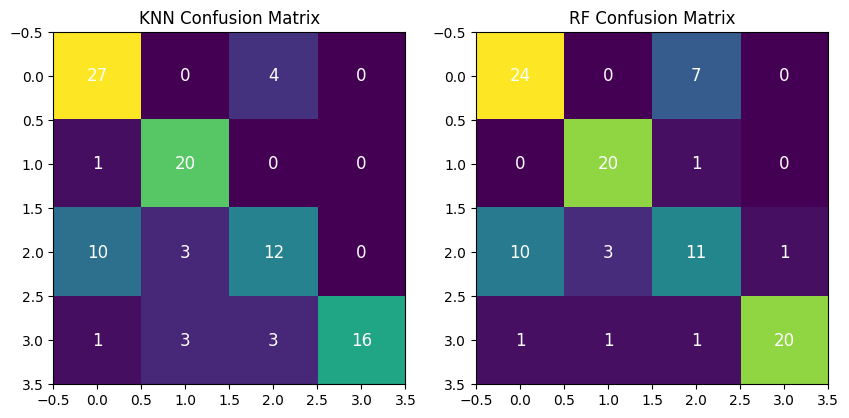

USING MIM for dimensionality reduction with args: {'standardize': True}
Reducing to 15 components.
KNN args: {}
Random Forest args: {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None, 'criterion': 'entropy'}

Selected top features: ['_HarmonicChangeDetectionFunction_Std'
 '_HarmonicChangeDetectionFunction_PeriodAmp' '_Fluctuation_Mean'
 '_Zero-crossingrate_Mean' '_Eventdensity_Mean' '_EntropyofSpectrum_Mean'
 '_HarmonicChangeDetectionFunction_Mean' '_AttackTime_Mean'
 '_Pulseclarity_Mean' '_Brightness_Mean' '_MFCC_Mean_2'
 '_Chromagram_Mean_12' '_Spectralskewness_Mean' '_MFCC_Mean_7'
 '_Chromagram_Mean_3']

Selected 15 components.
KNN metrics:
Accuracy: 0.68
Recall: 0.68
Precision: 0.70
F1 score: 0.68
Random forest metrics:
Accuracy: 0.77
Recall: 0.77
Precision: 0.77
F1 score: 0.77


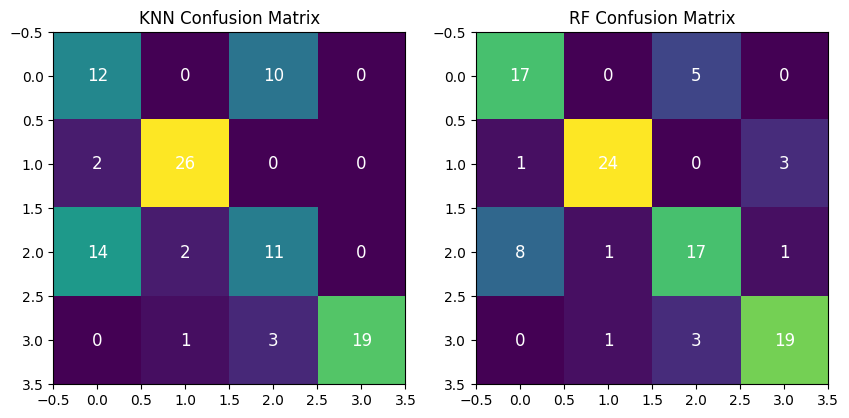

((0.68, 0.6768800844887801, 0.6958641215106732, 0.6821037888839746),
 (0.77, 0.7713966790053747, 0.7707525083612041, 0.7692888331475288))

In [15]:
test_method(mut_inf_dim_reduction, dim_red_kwargs={"standardize" : True}, N=5, plot_confusion_matrix=True,knn_kwargs={
    "n_neighbors": 4,
    "weights": "uniform"
})
DF = None

test_method(mut_inf_dim_reduction, dim_red_kwargs={"standardize" : True}, N=15, plot_confusion_matrix=True,rf_kwargs={
    "n_estimators": 100,
    "max_depth": 6,
    "min_samples_split": 3,
    "min_samples_leaf": 1,
    "max_features": None,
    "criterion": "entropy",
})